# Script for preprocessing of Tina's Calcium imaging data

### Dependencies: matplotlib, scikit image, h5py, numpy, pyqtgraph (interactive plots of 3D stacks), roi (custom python class for drawing rois)

### Overview of steps
1. Import tiff stack
2. Open using pyqtgraph (interactive browsing of data)
3. Simple movement correction
4. Draw ROIs
5. Extraction of time series from ROIs
6. Some visualizations of ROI time series

In [1]:
from skimage.io import imread, imshow
import h5py
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np
from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import flika as flk
from flika.window import Window as flw

%matplotlib inline

### 1. Import tiff stack

#### Choose and import tiff file (imaging data) and generate directory for storing analysis plots

In [2]:
parentDir = sep.join(getcwd().split(sep)[:-1])

rawtiff = 'JF549-BAPTA_MPM/170920/170920_549_z_bar3ccw_00001.tif'
[dye, date, expt] = rawtiff.split(sep)

dataDir = parentDir + sep + 'Data'
plotDir = parentDir + sep + 'Plots'

print(parentDir)
print(dataDir)
print(plotDir)

/Users/haberkernh/Documents/code/beeAnalysis
/Users/haberkernh/Documents/code/beeAnalysis/Data
/Users/haberkernh/Documents/code/beeAnalysis/Plots


In [3]:
# Generate directory where to save plots
saveDir = sep.join([plotDir,dye,date,expt[:-4]])
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

/Users/haberkernh/Documents/code/beeAnalysis/Plots/JF549-BAPTA_MPM/170920/170920_549_z_bar3ccw_00001


In [4]:
with open(dataDir + sep + rawtiff, 'rb') as fh:
    endofhead = 0 
    fpv = -1
    numVols = -1
    
    while(not endofhead):
        line = str(fh.readline()[:-1])
        
        # extract version
        if 'VERSION_' in line:
            print(line)
            
        # get channel info
        if 'hChannels' in line:
            if 'channelSave' in line:
                print(line)
                nCh = int(line[-2:-1])-1
        
        # get number of planes per z-stack
        if 'hStackManager' in line:
            if 'numFramesPerVolume' in line:
                print(line)
                fpv = int(line[-2:-1]) 
        if 'hFastZ' in line:
            if 'numVolumes' in line:
                print(line)
                lineString = str(line)
                numVols = int(lineString[lineString.find('=')+1:-1])
    
        if not 'SI' in line:
            endofhead = 1

b"SI.VERSION_MAJOR = '2016b'"
b"SI.VERSION_MINOR = '1'"
b'SI.hChannels.channelSave = 2'
b'SI.hFastZ.numVolumes = 104'


In [5]:
rawstack = imread(dataDir + sep + rawtiff)
stackshape = rawstack.shape
print(stackshape)

(728, 512, 512)


#### Adjust frame settings to match chosen file
These are parameters that can not be retreaved from the file header

In [6]:
caCh = 0

fps = 20 # check that with notes

numimgs = int(stackshape[0])

if not '_z_' in rawtiff:
    fpv = 1
    numVols = int(stackshape[0]/fpv)
elif fpv <0:
    fpv = int(stackshape[0]/numVols)


print("# frames: " + str(numimgs))
print("# volumes: " + str(numVols))
print("# frames per vol: " + str(fpv))

# frames: 728
# volumes: 104
# frames per vol: 7


#### Reshape tiff stack

In [7]:
stack5d = rawstack.reshape((int(stackshape[0]/(fpv*nCh)),fpv,nCh,stackshape[1], stackshape[2]))
print('Full dimensional stack: stack5d')
print(stack5d.shape)

print('Stack reduced to one channel: stack4d')
stack4d = np.squeeze(stack5d[:,:,caCh,:,:])

print(stack4d.shape)

Full dimensional stack: stack5d
(104, 7, 1, 512, 512)
Stack reduced to one channel: stack4d
(104, 7, 512, 512)


### 2. Open stack

In [8]:
flk.start_flika()

Starting flika


Starting flika inside IPython


In [9]:
if fpv==1:
    rawVidWin = flw(stack4d)
else: #stack images of z-stack in x-dimension
    rawVidWin = flw(stack4d.reshape(stack4d.shape[0], 
                             stack4d.shape[1] * stack4d.shape[2],
                             stack4d.shape[3]))

### Optional: Collapse volume using max projection

In [10]:
if fpv>1:
    stackMP = stack4d.max(axis=1)
    stackMP.shape

    # Visualise new stack
    #maxVidWin = flw(stackMP)

In [11]:
# Use max projection?
if fpv>1:
    tiffstack = stackMP
else:
    tiffstack = rawstack

numframes = tiffstack.shape[0]
print('number of frames: {}'.format(numframes))

number of frames: 104


### 3. Simple movement correction
#### Alignment to reference plane

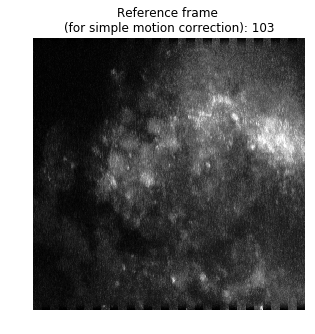

In [14]:
# pick reference frame, e.g. middle of last volume scanned.
refframe = int(numframes-1)

refimg = tiffstack[refframe]

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(refimg.T,cmap='Greys_r', vmin=0, origin='upper')
ax.axis('off')
ax.set_title('Reference frame \n(for simple motion correction): ' + str(refframe));

In [15]:
# compute cross correlation between ref. image and all other images in tiff stack
framecorr = np.zeros((numframes,1))

for frame in range(numframes):
    framecorr[frame] = np.corrcoef(tiffstack[frame].ravel(), refimg.ravel())[0,1]

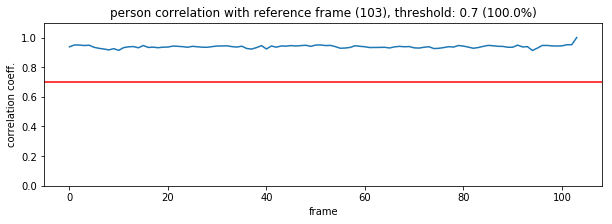

In [16]:
# Set threshold (min. correlation coefficient) for selection of frames
corrTH = 0.7

corrFig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(framecorr)
ax.set_ylabel('correlation coeff.')
ax.set_xlabel('frame')
ax.set_title('person correlation with reference frame ('+str(refframe)+
             '), threshold: '+str(corrTH)+
             ' ('+str(round(100*int(sum(framecorr>corrTH))/numframes,2))+'%)')
ax.axhline(y=corrTH, xmin=0, xmax=numframes, color='r')
ax.set_ylim(0, 1.1)
corrFig.savefig(saveDir+sep+'stackCorr_'+expt[:-4]+'.pdf', format = 'pdf')

In [17]:
# Select frames above threshold
slct_numframes = int(sum(framecorr>corrTH))
slct_frames = (framecorr>corrTH).astype('int')
slct_tiffstack = np.zeros((slct_numframes,tiffstack.shape[1],tiffstack.shape[2]))
for ind, frame in enumerate(np.where(framecorr>corrTH)[0]):
    slct_tiffstack[ind] = tiffstack[frame]

### 4. Draw ROI's using flika's menu

In [18]:
# Open with flika, select e.g. freehand form, right click on image and draw ROI
slctStackWin = flw(slct_tiffstack)
print(slct_tiffstack.shape)

(104, 512, 512)


### 5. Extraction of time series from ROIs

In [19]:
rois = slctStackWin.rois

#### Settings for computing dF/F

In [58]:
# Currently F_0 is estimated for the whole time series (ok, if time series is short)
baseLinePercent = 20
offset = 0.00001

#### Save ROI data to file

In [80]:
# Generate dictionary with all ROI information -- assumes max projection, i.e. 
roiData = {
    'imgData': rawtiff,
    'img': refimg,
    'numframes': slct_numframes,
    'slctframes': slct_frames,
    'fpv': fpv
}

# Save time series
F_raw = np.nan*np.ones((slct_numframes,len(rois)))
dFF = np.nan*np.ones((slct_numframes,len(rois)))
roiPts = []
for i, r in enumerate(rois):
    # get pixel coordinates defining the ROI
    roiPts.append(r.getPoints())
    
    # Compute the average of the pixels within this ROI in its window
    F_raw[:,i] = r.getTrace() 
    
    # Estimate baseline
    F_0 = np.percentile(r.getTrace(), baseLinePercent)
    if F_0 == 0: F_0 += offset
    
    # Compute dF/F_0 = (F_raw - F_0)/F_0
    dFF[:,i] = (r.getTrace() - F_0) / F_0

    # Note: could add background flourescence correction:  dF/F_0 = (F_raw - F_0)/(F_0 - F_b)
    #       F_b is measured in ROI far away from where we expect signal.
    
roiData['numRoi'] = len(rois)
roiData['Fraw'] = F_raw
roiData['DFF'] = dFF
roiData['Pts'] = roiPts

np.save(saveDir+sep+'roiData_'+expt[:-4],roiData) # save as npy file (easy to load into pyton)
np.savetxt(saveDir+sep+'roisTS_'+expt[:-4]+'.csv',roiTS, delimiter=',') # save as csv (easy to open e.g. in excel)

### 5. Some more visualizations of ROI time series
#### Visualize chosen ROIs and plot time series

In [81]:
from roiVisualization import myAxisTheme, illustrateRoiOutline, illustrateRoiArea, illustrateRoiTrace

ImportError: cannot import name 'myAxisTheme'

In [86]:
def myAxisTheme(myax):
    myax.get_xaxis().tick_bottom()
    myax.get_yaxis().tick_left()
    myax.spines['top'].set_visible(False)
    myax.spines['right'].set_visible(False)


def illustrateRoiOutline(roidat, ax, roicmap, title):
    from shapely.geometry.polygon import LinearRing
    
    ax.imshow(roidat['img'].T,cmap='Greys_r', vmin=0, origin='upper')
    
    for i, roi in enumerate(roidat['Pts']):
        roiOutl = LinearRing(roi)
        xr, yr = roiOutl.coords.xy
        ax.plot(xr, yr, color=roicmap.to_rgba(i), lw=2)
        ax.text(xr[0], yr[0], 'roi'+str(i+1), color='w', fontsize=10)
    
    ax.set_title(title)
    return ax

def illustrateRoiArea(roidat, ax, roicmap, title):
    from shapely.geometry.polygon import Polygon
    from descartes import PolygonPatch
    
    ax.imshow(roidat['img'].T,cmap='Greys_r', vmin=0, origin='upper')
    
    for i, roi in enumerate(roidat['Pts']):
        roiArea = Polygon(roi)
        
        roipatch = PolygonPatch(roiArea,alpha=0.7, color=roicmap.to_rgba(i))
        ax.add_patch(roipatch)
        
        ax.text(roi[0,0], roi[0,1], 'roi'+str(i+1), color='w', fontsize=10)
    ax.set_title(title)
    return ax
    
    
def illustrateRoiTrace(roidat, ax, roicmap, framerange, xlab, ylab, title):
    
    for i in range(roidat['numRoi']):
        ax.plot(roidat['DFF'][framerange,i],'-', color=roicmap.to_rgba(i))
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    
    ax.set_title(title)
    return ax

In [87]:
# generate roi color map
nrois = len(rois)
cNorm  = colors.Normalize(vmin=0, vmax=nrois)
roiCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Set2')

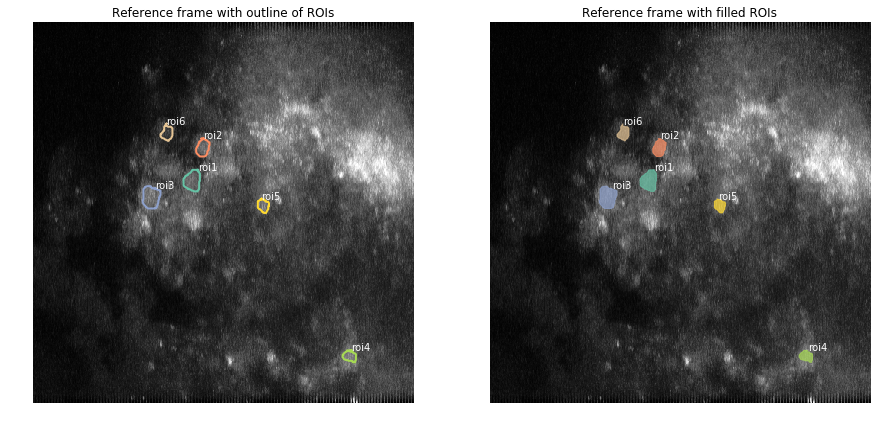

In [92]:
fig, axs = plt.subplots(1,2, figsize=(15,8))
axs[0] = illustrateRoiOutline(roiData, axs[0], roiCMap, 'Reference frame with outline of ROIs')
axs[1] = illustrateRoiArea(roiData, axs[1], roiCMap, 'Reference frame with filled ROIs')

for ax in axs:
    ax.axis('off')

fig.savefig(saveDir+sep+'roi-viz_'+expt[:-4]+'.pdf', format = 'pdf')

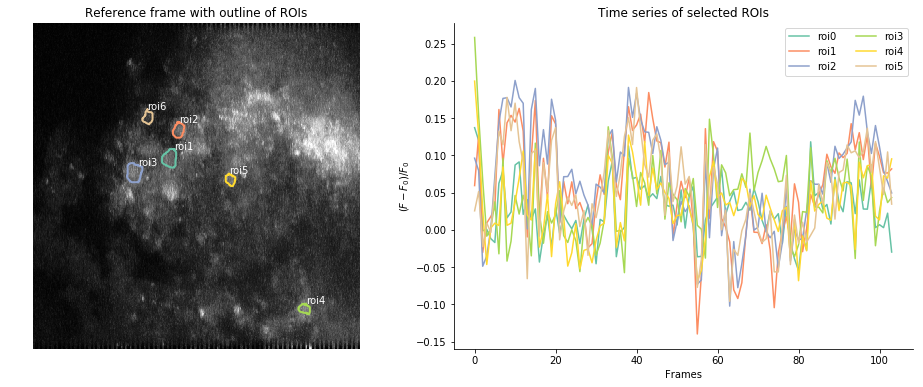

In [91]:
# Plot selected ROIs
start = 0
end = 500
slctFrames = np.arange(start, min(numframes, end))

# generate time vector
#time = np.linspace(ts/fps, te/fps, (te-ts))

fig, axs = plt.subplots(1,2, figsize=(16,6), gridspec_kw={'width_ratios':[1,1.3]})

axs[0] = illustrateRoiOutline(roiData, axs[0], roiCMap, 'Reference frame with outline of ROIs')
axs[1] = illustrateRoiTrace(roiData, axs[1], roiCMap, slctFrames,'Frames', '$(F - F_0) / F_0$', 'Time series of selected ROIs')

axs[1].legend(['roi'+str(i) for i in range(len(rois))], ncol=2)

myAxisTheme(axs[1])
axs[0].axis('off')

# Save after making adjustments through figure window GUI
fig.savefig(saveDir+sep+'roi-traces_'+expt[:-4]+'.pdf', format = 'pdf')

#### Plot correlations between all selected ROIs

In [93]:
fig, axs = plt.subplots(len(drawing.rois),len(drawing.rois), figsize=(15,14))

ts = 100
te = slct_numframes

for ri1, r1 in enumerate(drawing.rois[:]):
    
    coords1 = np.where(r1.get_mask())
    bl1 = slct_tiffstack[ts:te+1,coords1[0], coords1[1]].mean(1).mean(0)
    roi1 = (slct_tiffstack[ts:te+1,coords1[0], coords1[1]].mean(1)-bl1)/bl1

    for ri2, r2 in enumerate(drawing.rois[:ri1+1]):
        coords2 = np.where(r2.get_mask())
                
        bl2 = slct_tiffstack[ts:te+1,coords2[0], coords2[1]].mean(1).mean(0)
        roi2 = (slct_tiffstack[ts:te+1,coords2[0], coords2[1]].mean(1)-bl2)/bl2
    
        axs[ri1,ri2].plot(roi2, roi1, '.', alpha=0.3, color='black')
        
        axs[ri1,ri2].set_xlabel('ROI '+str(ri2+1))
        axs[ri1,ri2].set_ylabel('ROI '+str(ri1+1))
        axs[ri1,ri2].set_xlim(min(roi2),max(roi2))
        axs[ri1,ri2].set_ylim(min(roi1),max(roi1))
        
fig.tight_layout()
plt.show()

#fig.savefig(saveDir+sep+'roi-corr_'+expt[:-4]+'.pdf', format = 'pdf')

NameError: name 'drawing' is not defined